## Model Evaluation

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(memisc)))
library(emmeans)

# Load the data
load(file = "~/Documents/vcf/data/moderation.RData")
paste0("Initial sample: ", nrow(vcf_data))

[1] "Initial sample: 371"

## ANCOVA: Total Sample

In [2]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){   
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      republican + conservative + phi_trust_cat +
                      employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  republican + conservative + phi_trust_cat + 
                                  employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    lm_model <- with(bctrans,
              lm(linkfun(post) ~ group + wave + 
                                  republican + conservative + phi_trust_cat + 
                                  employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))    
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points,
        "lm_model" = lm_model))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")
    
    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                   
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

plot_qqs_hist <- function(object){
    op <- par(pty = "s", mfrow = c(2, 2))
    qqnorm(object$base_model$residuals, main = "QQ-Plot Fit to Raw Scores")
    qqline(object$base_model$residuals)
    qqnorm(object$model$residuals, main = "QQ-Plot Fit to Transformed Scores")
    qqline(object$model$residuals)
    object$base_model$residuals %>% hist(main = "Residuals (Raw)", freq = FALSE)  
    object$model$residuals %>% hist(main = "Residuals (Transformed)", freq = FALSE)
}

[1] "Intentions to Vaccinate (mean = 0.149; 95% CI = 0.008, 0.291; P = 0.039)"                     
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.242; 95% CI = 0.053, 0.432; P = 0.0125)"
[3] "COVID-19 Vaccine Confidence (mean = 0.052; 95% CI = -0.109, 0.212; P = 0.5271)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.093; 95% CI = -0.074, 0.26; P = 0.2762)"

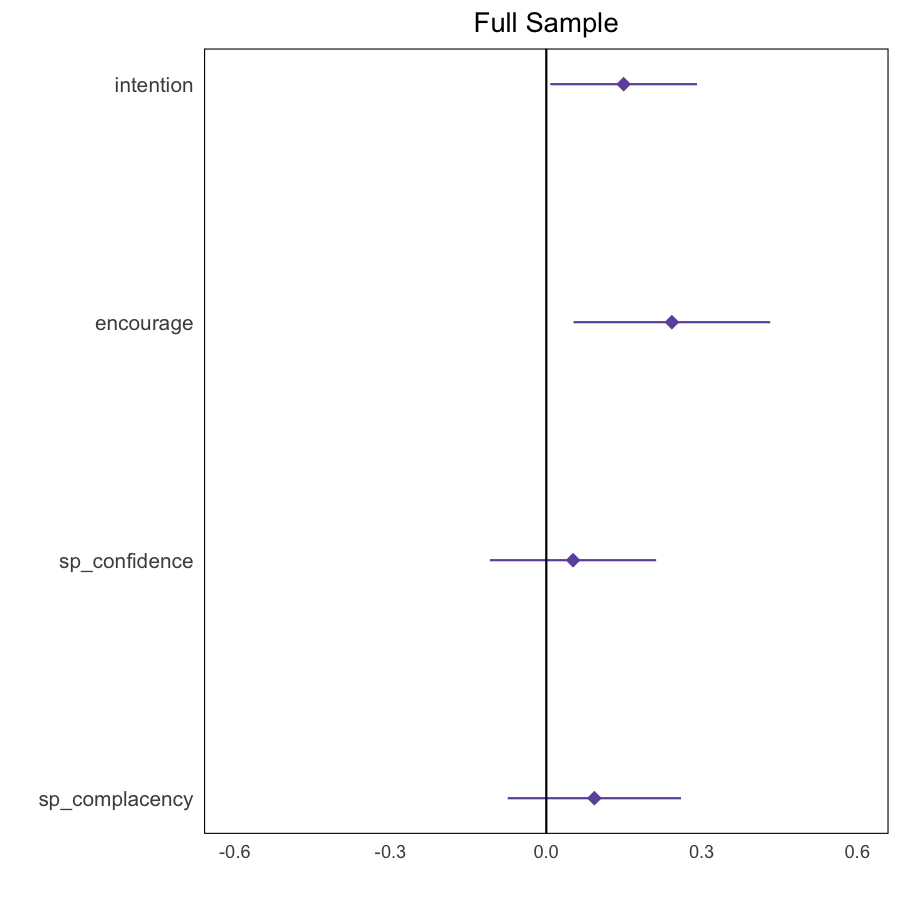

In [3]:
full_sample <- subgroup_ANCOVA(subgroup = vcf_data, label = "Full Sample", pad = 0)
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
full_sample$tbl
full_sample$plot

**ANCOVA where the factor variables only have two levels is the same as fitting a linear regression model.**

In [4]:
car::Anova(full_sample$intention$model, type = "III") %>% round(4)
full_sample$intention$lm_model %>% summary()

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.0880,1,1.5343,0.2163
group,0.2462,1,4.2956,0.0389
wave,0.0006,1,0.0097,0.9216
republican,0.0017,1,0.0289,0.8651
conservative,0.1178,1,2.0557,0.1525
phi_trust_cat,1.0631,1,18.5462,0.0000
employment2,0.0158,1,0.2748,0.6004
education2,0.0274,1,0.4784,0.4896
marital_status,0.0009,1,0.0162,0.8989



Call:
lm(formula = linkfun(post) ~ group + wave + republican + conservative + 
    phi_trust_cat + employment2 + education2 + marital_status + 
    gender + age + income2 + linkfun(pre), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65886 -0.14445 -0.03715  0.11173  0.77643 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.1013049  0.0817852   1.239   0.2163    
groupControl             -0.0524696  0.0253161  -2.073   0.0389 *  
waveWave 2               -0.0027202  0.0276365  -0.098   0.9216    
republicannonrep          0.0067178  0.0395011   0.170   0.8651    
conservativeconserv      -0.0555596  0.0387507  -1.434   0.1525    
phi_trust_cattrusting     0.1234251  0.0286600   4.307 2.15e-05 ***
employment2Working        0.0157284  0.0300014   0.524   0.6004    
education2some college    0.0222857  0.0322199   0.692   0.4896    
marital_statusMarried    -0.0035900  0.0282406  -0.127   0.8989    


**The difference in expected marginal means between treatment and control (i.e., 0.377-0.325 = 0.0525) is the same as the coefficient estimate for in the linear model.**

 group     emmean     SE  df lower.CL upper.CL
 Treatment  0.377 0.0249 357    0.328    0.426
 Control    0.325 0.0274 357    0.271    0.378

Results are averaged over the levels of: wave, republican, conservative, phi_trust_cat, employment2, education2, marital_status, gender, income2 
Results are given on the Box-Cox (lambda = -1.178) (not the response) scale. 
Confidence level used: 0.95 

Note: Use 'contrast(regrid(object), ...)' to obtain contrasts of back-transformed estimates



 contrast            estimate     SE  df t.ratio p.value
 Treatment - Control   0.0525 0.0253 357   2.073  0.0389

Results are averaged over the levels of: wave, republican, conservative, phi_trust_cat, employment2, education2, marital_status, gender, income2 
Note: contrasts are still on the Box-Cox (lambda = -1.178) scale 

Warning message in ratios && true.con && misc$tran %in% c("log", "log2", "log10", :
“'length(x) = 5 > 1' in coercion to 'logical(1)'”


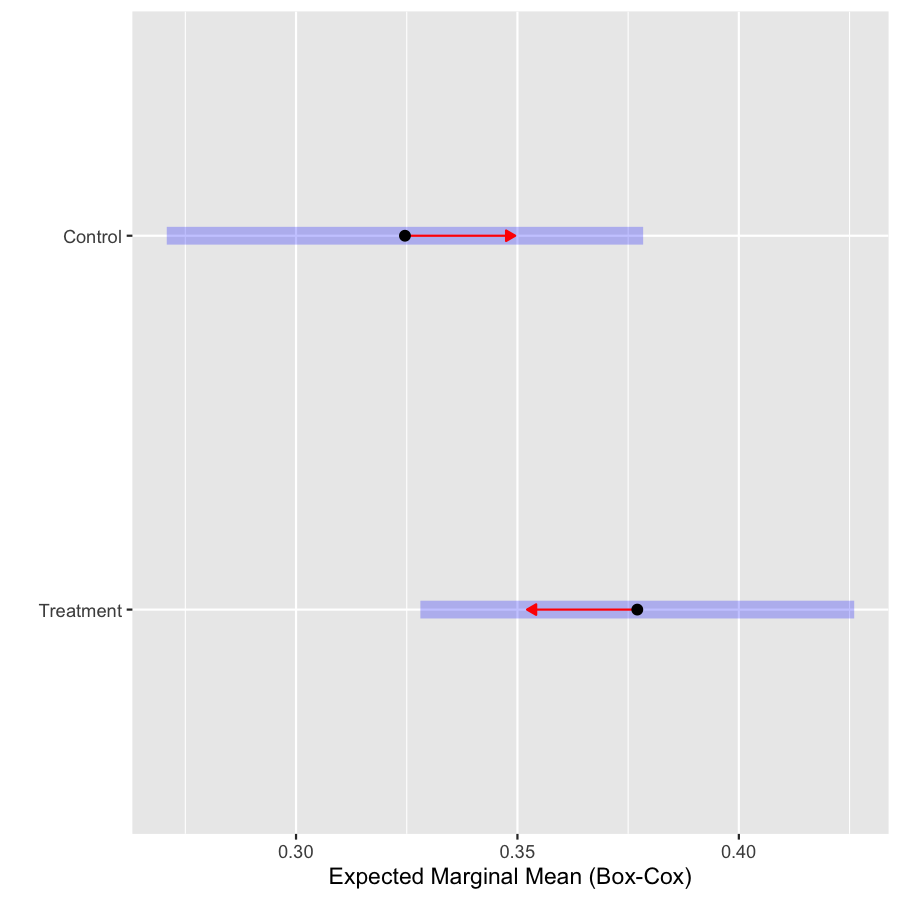

In [5]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
emm <- emmeans(full_sample$intention$model, "group")
emm

emm_diff <- suppressWarnings(pairs(emm))
emm_diff
plot(emm, comparisons = TRUE) + labs(x = "Expected Marginal Mean (Box-Cox)", y = "")

**We are reporting back-transformed treatment effects for our ANCOVA subgroup analyses.  We expect the post-test intentions to be 0.149 scale points above the control.**

In [6]:
# Estimated marginal means
emm_back <- emmeans(full_sample$intention$model, "group", type = "response")    
emm_back

# calculate differences in expected marginal means
rg <- ref_grid(full_sample$intention$model, "group")
emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
emm_diff_back

 group     response     SE  df lower.CL upper.CL
 Treatment     1.65 0.0738 357     1.51     1.81
 Control       1.51 0.0667 357     1.39     1.65

Results are averaged over the levels of: wave, republican, conservative, phi_trust_cat, employment2, education2, marital_status, gender, income2 
Confidence level used: 0.95 
Intervals are back-transformed from the Box-Cox (lambda = -1.178) scale 

 contrast            estimate    SE  df t.ratio p.value
 Treatment - Control    0.149 0.072 357   2.072  0.0390

Results are averaged over the levels of: wave, republican, conservative, phi_trust_cat, employment2, education2, marital_status, gender, income2 

### Intentions Model

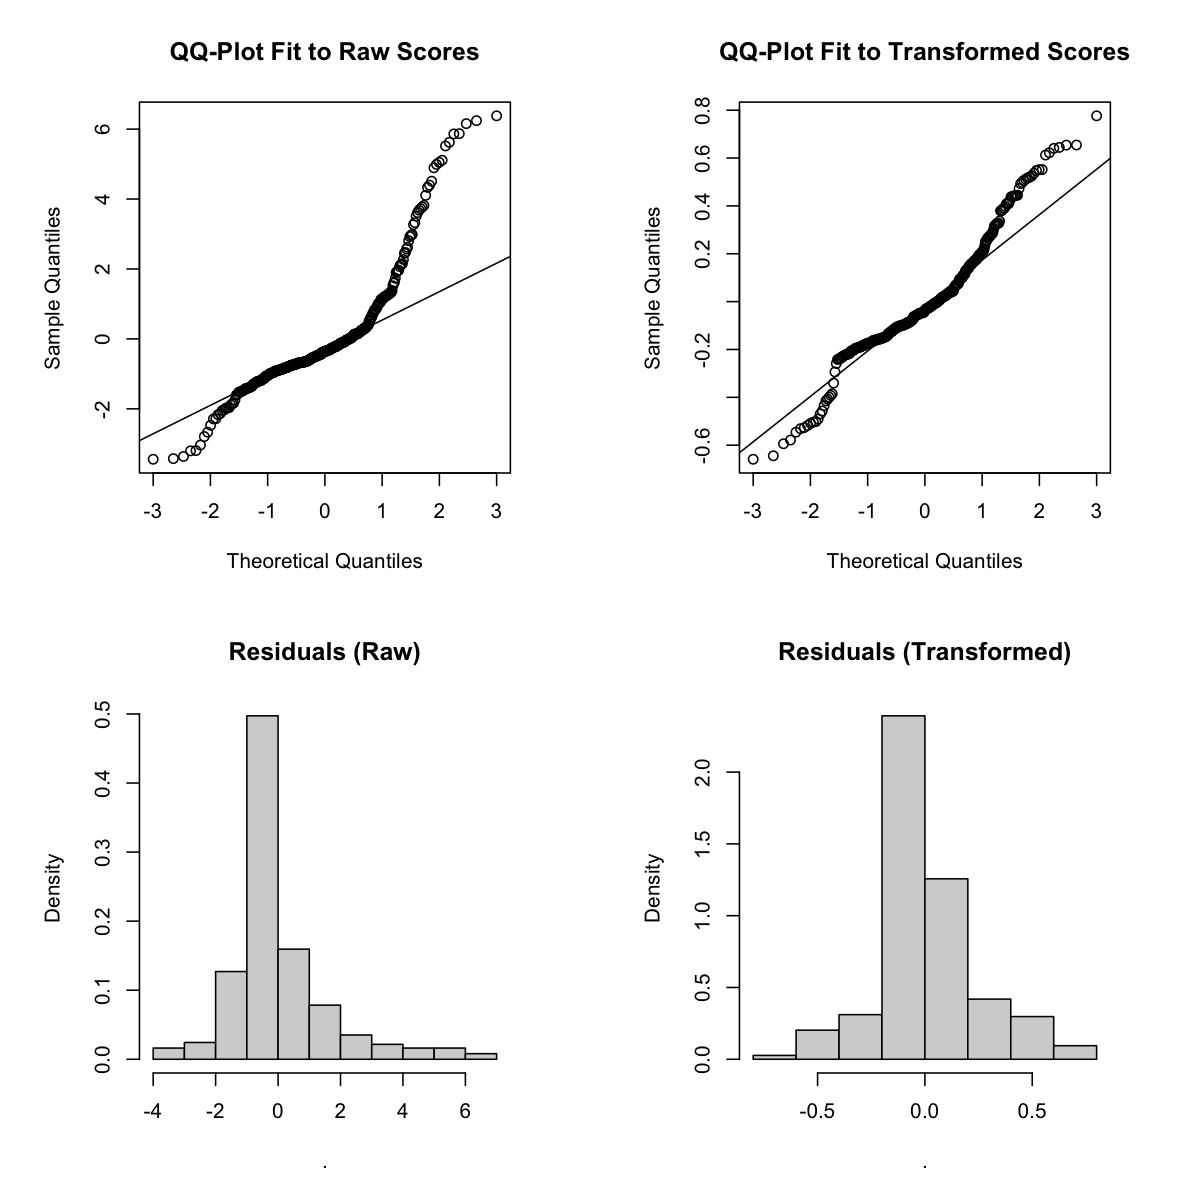

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
plot_qqs_hist(full_sample$intention)

### Intentions to Encourage Model

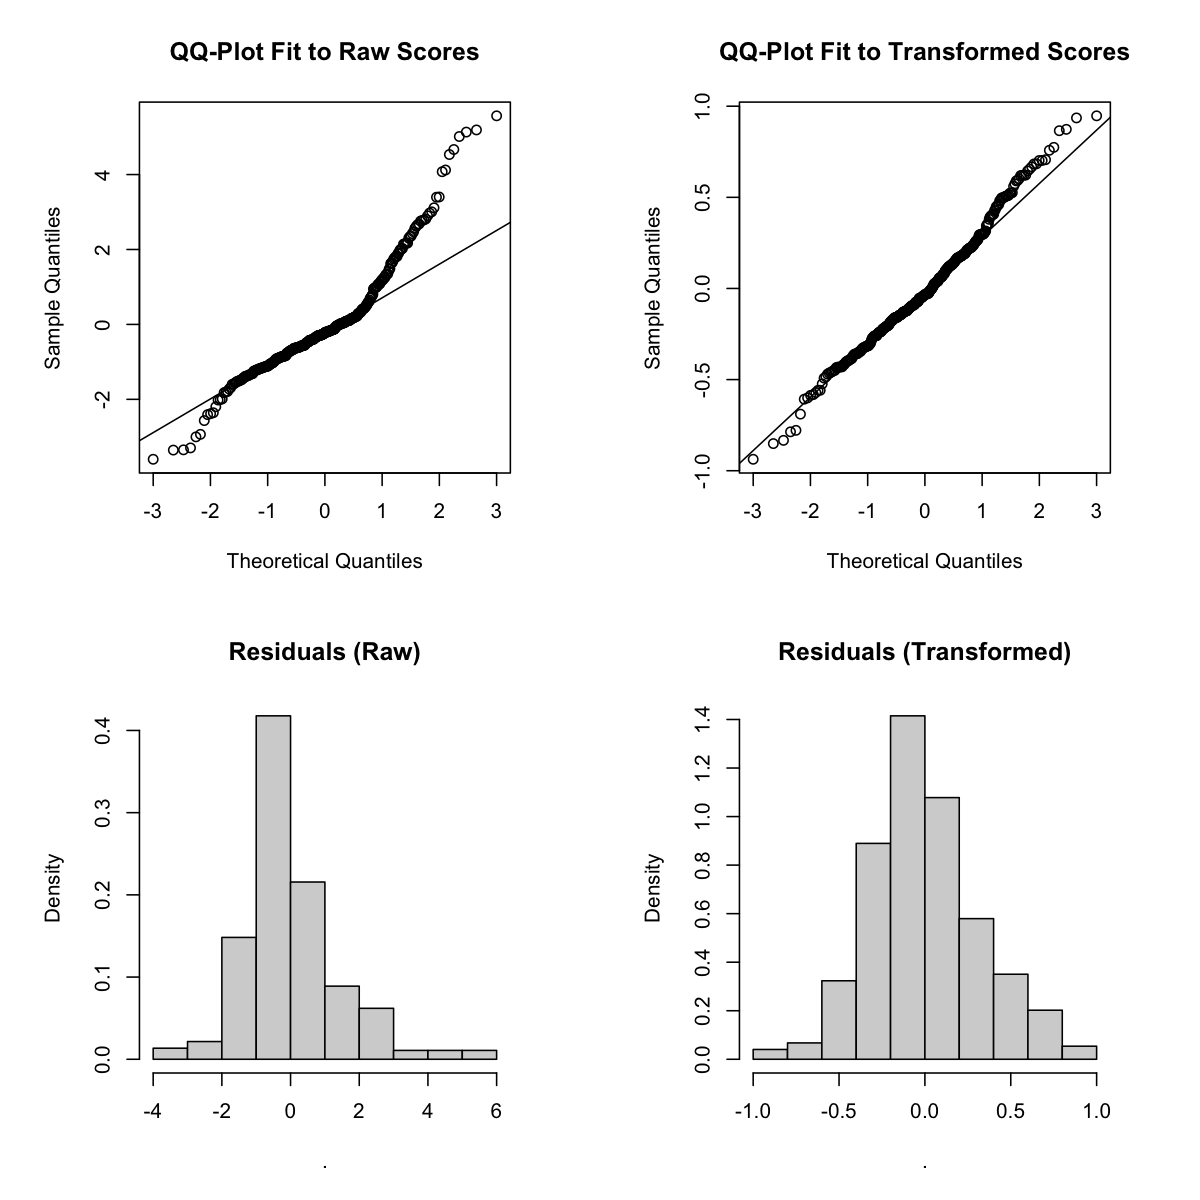

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
plot_qqs_hist(full_sample$encourage)

### Vaccine Confidence Model

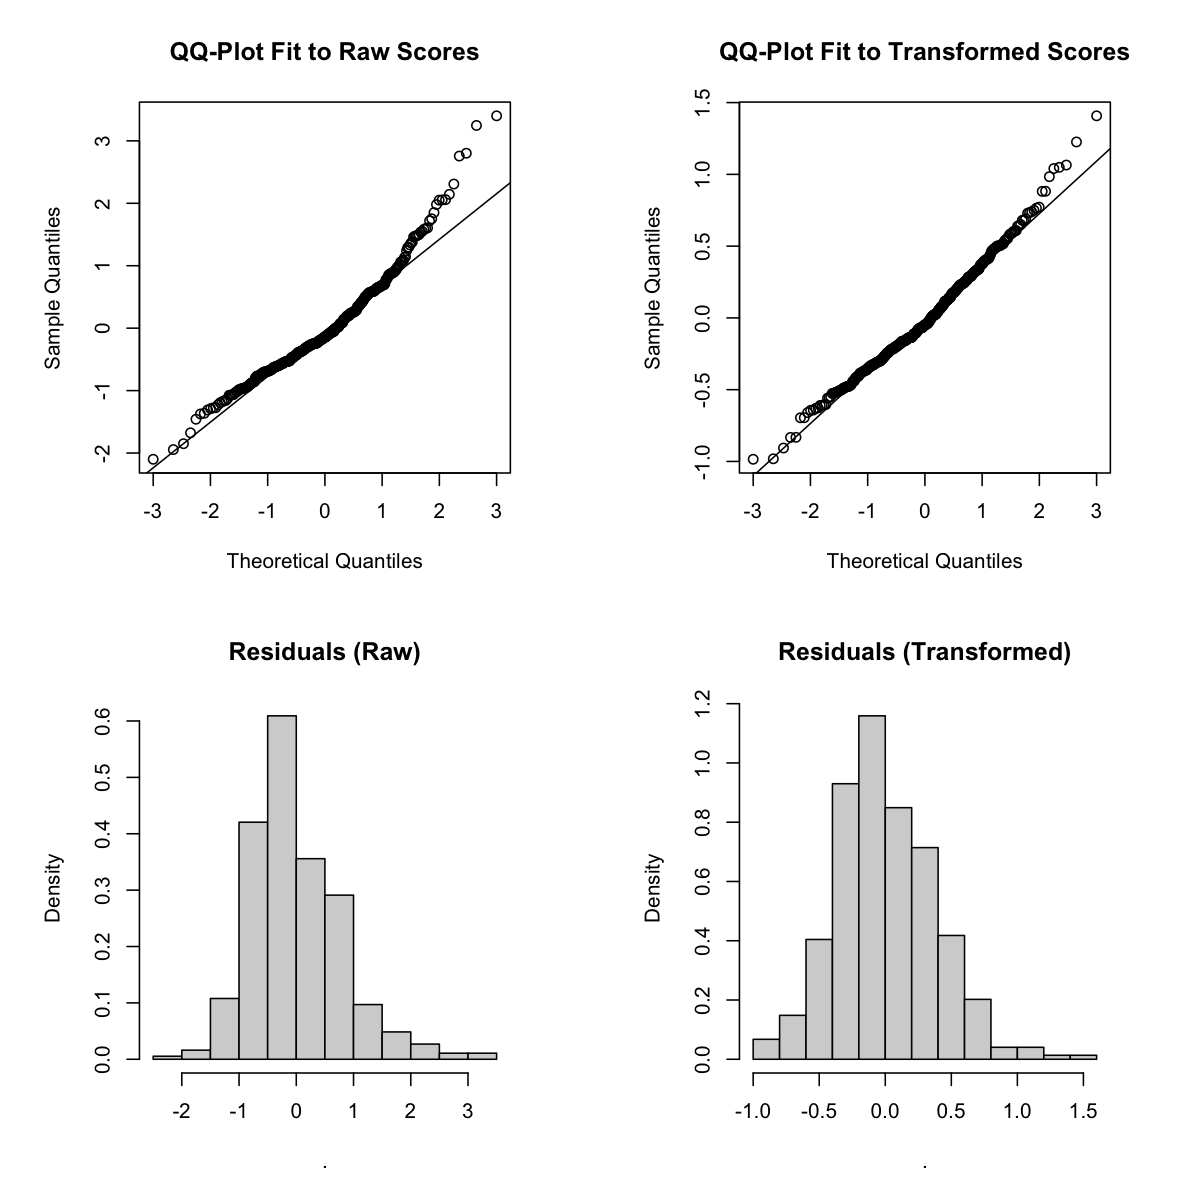

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
plot_qqs_hist(full_sample$sp_confidence)

### Vaccine Complacency Model

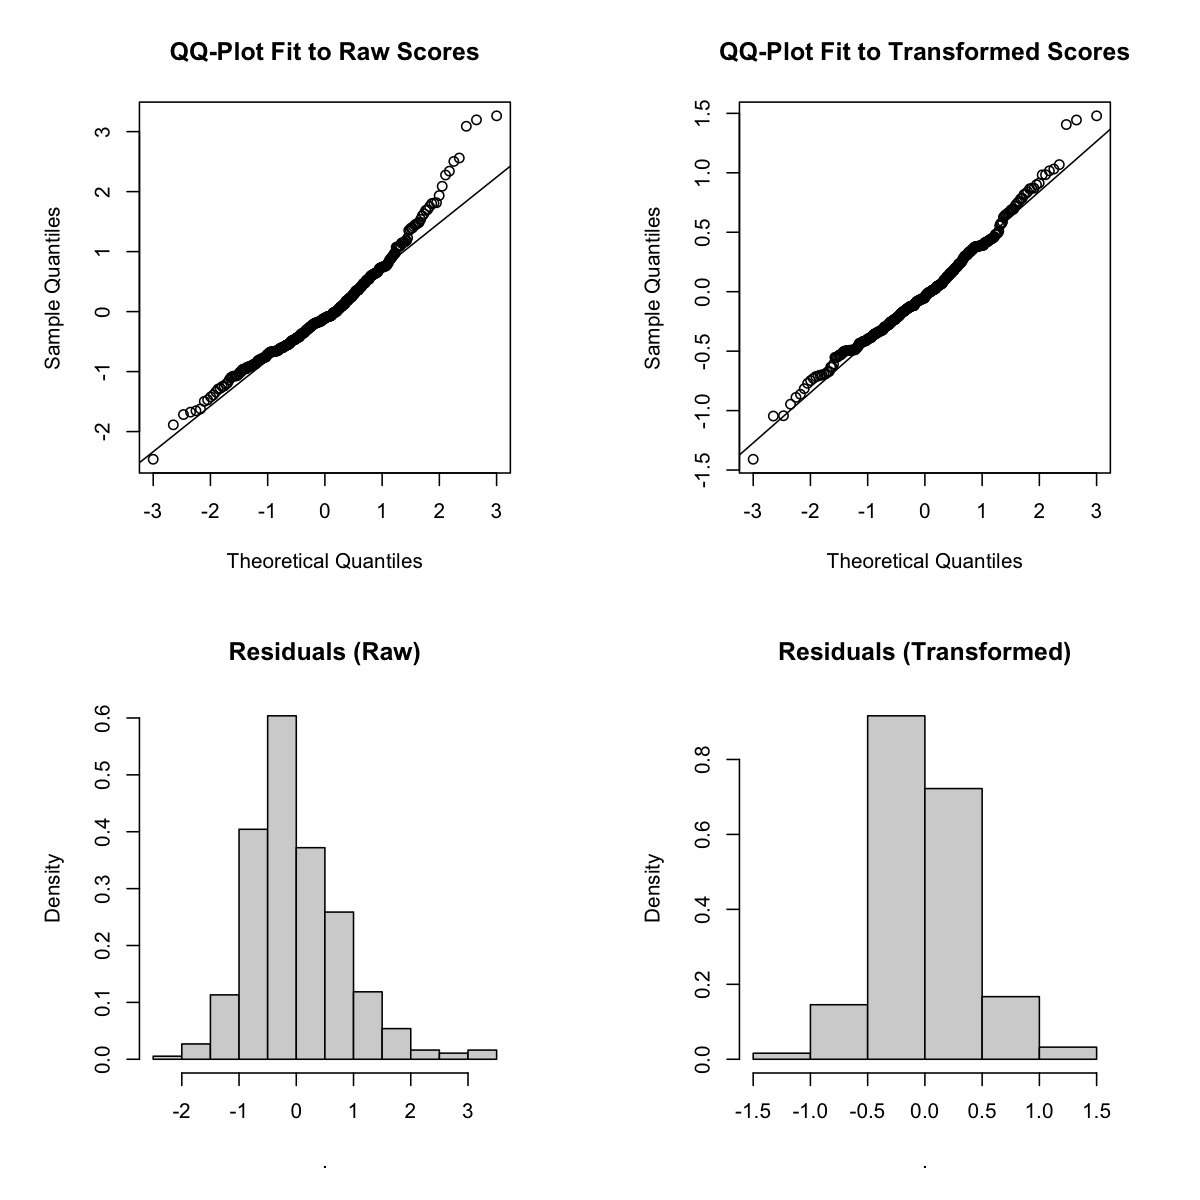

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 150)
plot_qqs_hist(full_sample$sp_complacency)